## 1: 导入与基础配置

In [1]:
import sys
import os
import numpy as np
import cv2
import glob
from tqdm import tqdm
import open3d as o3d
import matplotlib.pyplot as plt

# ================= 1. 路径设置 (复用 Step 2) =================
# 请确保 project_root 指向包含 rellis_utils 的目录
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "Projection"))
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from rellis_utils.lidar2img import load_from_bin, get_cam_mtx, get_mtx_from_yaml
    print("成功导入 rellis_utils")
except ImportError as e:
    print(f"导入失败: {e}")

# ================= 2. 数据集配置 =================
RELLIS_ROOT = '/home/xzy/datasets/Rellis-3D'
INFERENCE_DIR = '/home/xzy/Downloads/convertedRellis/rellisv3_edl_train-4/01_inferenced_npy'
SEQ_ID = '00004'

# 处理帧数范围
START_FRAME_IDX = 0
NUM_FRAMES = 10        # 建议跑 100-200 帧以观察融合效果
VOXEL_SIZE = 0.2        # 体素分辨率 (单位: 米)，越小越精细但内存消耗越大

# 图像与投影参数
PROJ_SHAPE = (1200, 1920) 
MAP_SHAPE = (600, 960)    
dist_coeff = np.array([-0.134313,-0.025905,0.002181,0.00084,0]).reshape((5,1))

# ================= 3. 加载标定与位姿 =================
# 相机参数
cam_info_path = os.path.join(RELLIS_ROOT, 'Rellis_3D_cam_intrinsic', 'Rellis-3D', SEQ_ID, 'camera_info.txt')
if not os.path.exists(cam_info_path): cam_info_path = os.path.join(RELLIS_ROOT, SEQ_ID, 'camera_info.txt')
trans_path = os.path.join(RELLIS_ROOT, SEQ_ID, 'transforms.yaml')
poses_file = os.path.join(RELLIS_ROOT, SEQ_ID, 'poses.txt')

P = get_cam_mtx(cam_info_path)
RT_os1_to_cam = get_mtx_from_yaml(trans_path)

def load_poses(pose_file):
    poses = []
    with open(pose_file, 'r') as f:
        for line in f:
            mat = np.eye(4)
            mat[:3, :] = np.fromstring(line, sep=' ').reshape(3, 4)
            poses.append(mat)
    return poses

all_poses = load_poses(poses_file)
print(f"标定加载完毕. P: {P.shape}, Poses: {len(all_poses)}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
成功导入 rellis_utils
标定加载完毕. P: (3, 3), Poses: 2059


## 2. 核心数学工具

### 证据理论 (Evidential Theory) 形式化定义

#### 1. 从 Dirichlet 分布到 Mass (Belief)
基于主观逻辑（Subjective Logic）与证据深度学习（Evidential Deep Learning, EDL）框架，对于 $K$ 个类别的分类问题，Dirichlet 分布的参数 $\boldsymbol{\alpha} = [\alpha_1, \dots, \alpha_K]$ 与 Dempster-Shafer 证据理论中的 Mass（或称 Belief）$b_k$ 及不确定性 $u$ 的映射关系定义如下：

$$
S = \sum_{k=1}^{K} \alpha_k
$$

$$
b_k = \frac{\alpha_k - 1}{S}, \quad \forall k \in \{1, \dots, K\}
$$

$$
u = \frac{K}{S}
$$

其中，需满足约束 $\sum_{k=1}^{K} b_k + u = 1$ 且 $\alpha_k \ge 1$。

#### 2. Dempster 组合规则 (Dempster's Rule of Combination)
给定两个独立的证据来源（例如两个不同视角的观测或时序上的前后帧），分别由 $( \mathbf{b}^{(1)}, u^{(1)} )$ 和 $( \mathbf{b}^{(2)}, u^{(2)} )$ 表示。利用 Dempster 组合规则进行融合，得到新的联合置信度。

首先计算**冲突因子 (Conflict Factor)** $C$，表示两个证据之间相互矛盾的程度：

$$
C = \sum_{i \neq j} b_i^{(1)} b_j^{(2)}
$$

融合后的 Mass $b_k^{new}$ 和 Uncertainty $u^{new}$ 计算如下：

$$
b_k^{new} = \frac{1}{1-C} \left( b_k^{(1)} b_k^{(2)} + b_k^{(1)} u^{(2)} + b_k^{(2)} u^{(1)} \right)
$$

$$
u^{new} = \frac{1}{1-C} \left( u^{(1)} u^{(2)} \right)
$$

该规则有效地利用了不确定性信息：当一方非常确信（$u$ 很小）而另一方不确定（$u$ 很大）时，融合结果将偏向确信的一方。

In [2]:
# ================= 证据理论 (Evidential Theory) 核心函数 =================

def alpha_to_mass(alpha):
    """
    将 Dirichlet 参数 alpha 转换为 DS Mass 和 Uncertainty
    Input: alpha (..., K)
    Output: mass (..., K), uncertainty (..., 1)

    对于 K 个类别的分类问题：
    alpha: Dirichlet 分布的参数
    mass: 证据理论中的 Mass（或称 Belief, b）
    u:    证据理论中的 不确定性
    """
    # 确保 alpha >= 1.0 (防止数值下溢)
    alpha = np.maximum(alpha, 1.0001)
    
    S = np.sum(alpha, axis=-1, keepdims=True) # S = sum(alpha)
    K = alpha.shape[-1]
    
    # Belief/Mass k = (alpha_k - 1) / S
    mass = (alpha - 1.0) / S
    
    # Uncertainty = K / S
    uncertainty = K / S
    
    # 数值截断：确保 mass 和 uncertainty 在 [0, 1] 之间，且和为 1
    # 虽然理论上公式保证了这一点，但浮点误差可能导致溢出
    mass = np.clip(mass, 0.0, 1.0)
    uncertainty = np.clip(uncertainty, 0.0, 1.0)
    
    return mass, uncertainty

def dempster_fusion_numpy(m1, m2, u1, u2):
    """
    DS 组合规则 (Vectorized Numpy Version)
    融合两个 Mass 分布 m1 (old), m2 (new observation)

    m: Dempster-Shafer 证据理论中的 Mass（或称 Belief）b
    u: Dempster-Shafer 证据理论中的 不确定性 
    """
    # 维度检查与广播处理
    if m1.ndim == 1: m1 = m1[None, :]
    if m2.ndim == 1: m2 = m2[None, :]
    if np.isscalar(u1): u1 = np.array([u1])
    if np.isscalar(u2): u2 = np.array([u2])
    
    if u1.ndim == 0: u1 = u1[None] # Handle scalar array
    if u2.ndim == 0: u2 = u2[None]
    # 确保 u1, u2 维度为 (Batch, 1) 以便广播
    if u1.ndim == 1: u1 = u1[:, None]
    if u2.ndim == 1: u2 = u2[:, None]

    
    # --- 1. 计算冲突因子 C (优化版) ---
    # 原逻辑：Sum(OuterProduct) - Sum(Diagonal)
    # 优化逻辑：Sum(m1) * Sum(m2) - Sum(m1 * m2)
    # 这种方式避免了构建巨大的 [Batch, K, K] 矩阵，速度更快，内存更省
    
    sum_m1 = np.sum(m1, axis=-1, keepdims=True)
    sum_m2 = np.sum(m2, axis=-1, keepdims=True)
    
    # 两个证据支持同一类的部分 (Diagonal term)
    consensus = m1 * m2
    sum_diag = np.sum(consensus, axis=-1, keepdims=True)
    
    # 所有可能的组合 (包括冲突和共识)
    sum_all = sum_m1 * sum_m2
    
    # 冲突因子 C
    C = sum_all - sum_diag
        
    # --- 2. 归一化因子 (数值稳定处理) ---
    norm_factor = 1.0 - C
    
    # 防止除零和极小分母
    # 这里的 epsilon 可以稍微大一点，或者使用 soft clipping
    EPS = 1e-6
    norm_factor = np.clip(norm_factor, EPS, None) 
    
    # --- 3. 融合 Mass ---
    # 公式：m_new = (m1*m2 + m1*u2 + m2*u1) / (1-C)
    term1 = consensus           # m1[i] * m2[i]
    term2 = m1 * u2             # m1[i] * u2 (广播)
    term3 = m2 * u1             # m2[i] * u1 (广播)
    
    m_new = (term1 + term2 + term3) / norm_factor
    
    # --- 4. 融合 Uncertainty ---
    # 公式：u_new = (u1*u2) / (1-C)
    u_new = (u1 * u2) / norm_factor
    
    # --- 5. 最后的数值安全检查 ---
    # 极端冲突下，结果可能溢出或 NaN，这里做兜底
    # 替换 NaN 为 0，Inf 为 1 (或者均匀分布)
    if np.any(np.isnan(m_new)) or np.any(np.isinf(m_new)):
        # print("Warning: NaN/Inf detected in DS fusion. Resetting to uncertainty.")
        m_new = np.nan_to_num(m_new, nan=0.0, posinf=1.0, neginf=0.0)
        u_new = np.nan_to_num(u_new, nan=1.0, posinf=1.0, neginf=1.0)

    # 再次截断，防止浮点漂移导致 >1
    m_new = np.clip(m_new, 0.0, 1.0)
    u_new = np.clip(u_new, 0.0, 1.0)

    # --- 6. 最终严格归一化 (Optional but Recommended) ---
    # 因为前面的 clipping 可能破坏了 sum(m) + u = 1 的约束
    # 重新计算 total 并在最后一维进行除法
    total = np.sum(m_new, axis=-1, keepdims=True) + u_new
    
    # 再次防止 total 为 0 (虽然极不可能，但为了绝对安全)
    total = np.maximum(total, 1e-9)
    
    m_new = m_new / total
    u_new = u_new / total
    
    return m_new, u_new

## 3. Voxel Map 类定义

In [3]:
import numpy as np

class EvidentialVoxelMap:
    def __init__(self, resolution=0.2, num_classes=9):
        self.resolution = resolution
        self.num_classes = num_classes
        
        # 1. 核心存储: 稀疏体素地图
        # Key=(x,y,z) tuple, Value={'mass': np.array, 'uncertainty': float, 'count': int}
        self.voxels = {} 
        
        # ================= [新增] 方法一：不确定性监控容器 =================
        
        # A. 全局监控: 记录每一帧输入数据的平均不确定性 (用于检测整体环境/传感器质量)
        self.history_global_unc = [] 
        
        # B. 局部探针: 记录特定体素的历史不确定性变化 (用于绘制 decay 曲线)
        # self.probed_indices: 存储我们需要"监视"的体素索引集合 set((x,y,z))
        # 使用 set 集合存储 tuple 索引，确保查询速度 O(1)
        self.probed_indices = {
            (-25, -49, -5), (-30, -47, -5), (-25, -44, -6), (-48, -76, -4), (-25, -43, -5),
            (-43, -10, -5), (-36, -57, -3), (1, -156, -7),  (2, -157, -7),  (-38, -79, -5),
            (-10, -124, -6),(1, -157, -7),  (-2, -151, -6), (-46, -96, -4), (-48, -79, -3),
            (-39, -81, -3), (-29, -95, -6), (-5, -52, -6),  (-2, -153, -7), (-7, -122, -6),
            (-11, -126, -6),(2, -156, -7),  (-28, -90, -6), (-1, -151, -7), (0, -151, -7),
            (-1, -154, -7), (-27, -47, -5), (-26, -42, -5), (-10, -113, -6),(-26, -43, -5),
            (-15, -42, -7), (-32, -93, -6), (-27, -63, -6), (-2, -69, -6),  (-9, -125, -6),
            (-49, -83, -3), (-32, -92, -6), (-12, -123, -6),(-11, -124, -6),(-39, -62, -5),
            (-39, -82, -3), (-50, -83, -3), (41, -46, -5),  (1, -154, -7),  (-25, -88, -6),
            (-29, -96, -6),(2, -158, -7),  (-25, -48, -6), (-28, -43, -5), (-9, -127, -6)
        }
        
        # self.watched_voxels: 存储监视结果
        # Key=(x,y,z), Value=[u_t0, u_t1, u_t2, ...] (不确定性列表)
        self.watched_voxels = {}

    def add_probe_point(self, point):
        """
        [新增] 添加一个物理坐标点作为探针
        Input: point [x, y, z] (numpy array or list)
        """
        # 将物理坐标转换为体素索引
        idx = tuple(np.floor(np.array(point) / self.resolution).astype(int))
        self.probed_indices.add(idx)
        print(f"已添加探针监控: 物理坐标 {point} -> 体素索引 {idx}")

    def update(self, points, alphas):
        """
        更新地图状态
        points: (N, 3) 世界坐标系下的点
        alphas: (N, K) 对应的 Dirichlet 参数
        """
        # 1. 转换观测值为 Mass/Uncertainty
        obs_masses, obs_uncs = alpha_to_mass(alphas)
        
        # ================= [新增] 监控逻辑 1: 记录本帧全局平均不确定性 =================
        # 这反映了当前这一帧 LiDAR 数据经过深度学习网络后的整体"自信程度"
        frame_avg_unc = np.mean(obs_uncs)
        self.history_global_unc.append(frame_avg_unc)
        # =========================================================================
        
        # 2. 计算体素索引
        voxel_indices = np.floor(points / self.resolution).astype(int)
        
        # 3. 逐点融合
        # 构建当前帧的临时字典: idx -> list of indices
        unique_indices, inv_inds = np.unique(voxel_indices, axis=0, return_inverse=True)
        
        # 遍历当前帧涉及的每一个体素
        for i, idx_arr in enumerate(unique_indices):
            idx_tuple = tuple(idx_arr)
            
            # 找到当前帧所有属于该体素的点
            mask = (inv_inds == i)
            
            # === 策略 A: 帧内取平均 (简单且有效) ===
            avg_mass = np.mean(obs_masses[mask], axis=0)
            avg_unc = np.mean(obs_uncs[mask])
            
            if idx_tuple not in self.voxels:
                # 初始化
                self.voxels[idx_tuple] = {
                    'mass': avg_mass,         # (K,)
                    'uncertainty': avg_unc,   # scalar
                    'count': 1
                }
            else:
                # 融合 (Temporal Fusion)
                old_data = self.voxels[idx_tuple]
                
                # 注意: dempster_fusion_numpy 需要确保返回维度正确
                new_m, new_u = dempster_fusion_numpy(
                    old_data['mass'], avg_mass, 
                    old_data['uncertainty'], avg_unc
                )
                
                # 更新状态
                # 确保保存为一维数组和标量，防止嵌套 numpy array
                self.voxels[idx_tuple]['mass'] = new_m.flatten() if isinstance(new_m, np.ndarray) else new_m
                self.voxels[idx_tuple]['uncertainty'] = float(new_u) # 强制转 float，更加安全
                self.voxels[idx_tuple]['count'] += 1

            # ================= [新增] 监控逻辑 2: 更新探针历史 =================
            # 如果当前更新的体素在我们的监视列表中，记录其融合后的新不确定性
            if idx_tuple in self.probed_indices:
                if idx_tuple not in self.watched_voxels:
                    self.watched_voxels[idx_tuple] = []
                
                # 记录最新的后验不确定性
                current_u = self.voxels[idx_tuple]['uncertainty']
                self.watched_voxels[idx_tuple].append(current_u)
            # =================================================================

    def to_pointcloud(self):
        """将体素地图导出为 numpy 数组用于可视化"""
        if not self.voxels:
            return None, None, None
            
        pts = []
        labels = []
        uncs = []
        
        for idx, data in self.voxels.items():
            # 恢复中心坐标
            pt = (np.array(idx) * self.resolution) + (self.resolution / 2.0)
            pts.append(pt)
            
            # 获取最大概率类别
            label = np.argmax(data['mass'])
            labels.append(label)
            
            # 获取不确定性
            uncs.append(data['uncertainty'])
            
        return np.array(pts), np.array(labels), np.array(uncs)

    def prune(self, min_count=2):
        """(可选) 清除只观测到一两次的噪声体素"""
        keys_to_remove = [k for k, v in self.voxels.items() if v['count'] < min_count]
        for k in keys_to_remove:
            # 如果删除了体素，记得也要从探针历史里清理（可选，视需求而定）
            del self.voxels[k]
        print(f"已修剪 {len(keys_to_remove)} 个噪声体素")

# 必要的外部函数依赖 (确保已定义)
# from your_utils import alpha_to_mass, dempster_fusion_numpy

## 4. 主循环

In [4]:
# ================= 辅助投影函数 (复用 Step 2) =================
def project_and_get_data(lidar_file, npy_file, P, RT, img_size, map_shape):
    """
    return:
        final_points: 原始点云数据，但是过滤只保留了可以在图像上找到对应点的
        point_alphas: 图像语义概率，有一个形状的转换
    """
    # 加载数据
    points = load_from_bin(lidar_file)
    prob_map = np.load(npy_file) # 这是 alpha map (H_map, W_map, K)
    
    # 投影
    h, w = img_size
    xyz_h = np.hstack((points, np.ones((points.shape[0], 1))))
    xyz_cam = (RT @ xyz_h.T).T[:, :3]
    
    # Z轴过滤
    mask_z = xyz_cam[:, 2] > 3.0 
    xyz_cam = xyz_cam[mask_z]
    points = points[mask_z]
    
    # cv2 投影
    img_points, _ = cv2.projectPoints(xyz_cam, np.zeros(3), np.zeros(3), P, dist_coeff)
    img_points = img_points.squeeze()
    
    # 图像范围过滤
    u, v = img_points[:, 0], img_points[:, 1]
    mask_uv = (u >= 0) & (u < w) & (v >= 0) & (v < h)
    
    final_u = u[mask_uv]
    final_v = v[mask_uv]
    final_points = points[mask_uv] # Local LiDAR Frame
    
    # 采样 .npy (Alpha)
    # 注意 map_shape 和 img_shape 的比例
    scale_x = map_shape[1] / w
    scale_y = map_shape[0] / h
    
    u_map = np.clip((final_u * scale_x).astype(int), 0, map_shape[1]-1)
    v_map = np.clip((final_v * scale_y).astype(int), 0, map_shape[0]-1)
    
    # 获取每个点的 alpha 向量 (N, K)
    # 注意 prob_map 形状通常是 (H, W, K) 或 (K, H, W)，请根据实际情况调整 transpose
    # 假设 prob_map 是 (K, H, W)，如 Step 2 所述
    if prob_map.shape[0] == 9: # Channels first
        point_alphas = prob_map[:, v_map, u_map].T 
    else: # Channels last
        point_alphas = prob_map[v_map, u_map, :]
        
    return final_points, point_alphas

# ================= 主执行流程 =================

# 1. 初始化地图
global_map = EvidentialVoxelMap(resolution=VOXEL_SIZE, num_classes=9)

print(f"开始 Evidential Mapping (Frames {START_FRAME_IDX} - {START_FRAME_IDX + NUM_FRAMES})...")

for i in tqdm(range(START_FRAME_IDX, START_FRAME_IDX + NUM_FRAMES)):
    frame_str = f"{i:06d}"
    
    # 构建路径
    lidar_path = os.path.join(RELLIS_ROOT, SEQ_ID, 'os1_cloud_node_kitti_bin', f"{frame_str}.bin")
    npy_pattern = os.path.join(INFERENCE_DIR, SEQ_ID, f"frame{frame_str}-*.npy")
    npy_matches = glob.glob(npy_pattern)
    
    if not os.path.exists(lidar_path) or not npy_matches:
        continue
        
    # 1. 获取单帧数据 (Local Frame)
    pts_local, alphas = project_and_get_data(
        lidar_path, npy_matches[0], P, RT_os1_to_cam, PROJ_SHAPE, MAP_SHAPE
    )
    
    if len(pts_local) == 0: continue
    
    # 2. 转到世界坐标系 (World Frame)
    T_curr = all_poses[i]
    pts_homo = np.hstack((pts_local, np.ones((pts_local.shape[0], 1))))
    pts_world = (T_curr @ pts_homo.T).T[:, :3]
    
    # 3. 更新体素地图
    global_map.update(pts_world, alphas)

# (可选) 修剪噪声
global_map.prune(min_count=2)

print(f"建图完成! 总体素数量: {len(global_map.voxels)}")

开始 Evidential Mapping (Frames 0 - 10)...


100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.11it/s]

已修剪 1039 个噪声体素
建图完成! 总体素数量: 3054


## 5. 可视化 (不确定性与语义)

In [5]:
import numpy as np

def get_rellis_colors(labels, mode='auto', verbose=True):
    """
    获取 Rellis-3D 的颜色映射，支持原始标签(Raw)和归类标签(Group)。
    
    参数:
        labels: (N,) 的整数数组/列表
        mode: 
            'auto': 自动判断。如果 max(label) > 8 则认为是 'raw'，否则认为是 'group'。
            'raw':  强制认为是原始 ID (0-34)。
            'group': 强制认为是归类 ID (0-8)。
        verbose: 是否打印详细的映射信息 (True/False)。
        
    输出:
        colors: (N, 3) 的 float 数组 (0.0-1.0)
    """
    labels = np.array(labels, dtype=int)
    if labels.size == 0:
        return np.zeros((0, 3))

    # ================= Data Definition =================
    # 1. Raw ID (0-34) -> Group ID (0-8)
    # 索引为 Raw ID，值为 Group ID
    raw_to_group_map = np.zeros(35, dtype=int)
    mapping_data = {
        0:0, 1:6, 2:5, 3:7, 4:8, 5:3, 6:2, 7:1, 8:3, 9:3, 
        10:4, 11:5, 12:3, 13:6, 14:5, 15:6, 16:3, 17:3, 18:0, 
        19:8, 20:3, 21:0, 22:3, 23:4, 24:3, 27:0, 31:2, 33:6, 34:0
    }
    for k, v in mapping_data.items():
        if k < 35: raw_to_group_map[k] = v

    # 2. Group ID (0-8) -> RGB (0-255)
    group_rgb_dict = {
        0: [0, 0, 0],       # void
        1: [196, 255, 255], # sky
        2: [0, 0, 255],     # water
        3: [204, 153, 255], # object (pole, barrier, etc)
        4: [255, 255, 0],   # paved (asphalt, concrete)
        5: [255, 153, 204], # unpaved (mud, rubble)
        6: [153, 76, 0],    # brown (dirt, mulch)
        7: [111, 255, 74],  # green (grass)
        8: [0, 102, 0]      # vegetation (tree, bush)
    }
    
    # 3. Group ID -> Name (for logging)
    group_names = {
        0: "Void", 1: "Sky", 2: "Water", 3: "Object", 4: "Paved", 
        5: "Unpaved", 6: "Brown(Dirt)", 7: "Green(Grass)", 8: "Vegetation"
    }

    # ================= Mode Selection =================
    max_val = np.max(labels)
    
    if mode == 'auto':
        # 启发式判断：如果存在大于8的标签，一定是Raw；
        # 如果全都在0-8之间，优先假设是Group (因为通常可视化时如果是Raw，很难完全避开>8的ID)
        if max_val > 8:
            current_mode = 'raw'
        else:
            current_mode = 'group'
    else:
        current_mode = mode

    # ================= Mapping Execution =================
    
    # 最终用于查颜色的索引 (Group IDs)
    target_groups = None 

    if current_mode == 'raw':
        # 越界处理：超过34的全部设为0 (Void)
        safe_labels = labels.copy()
        safe_labels[safe_labels >= 35] = 0
        target_groups = raw_to_group_map[safe_labels]
    else: # mode == 'group'
        # 越界处理：超过8的全部设为0 (Void)
        target_groups = labels.copy()
        target_groups[target_groups > 8] = 0
    
    # 映射颜色
    # 先构建一个 (9, 3) 的颜色查找表数组
    color_lookup = np.zeros((9, 3))
    for i in range(9):
        color_lookup[i] = group_rgb_dict[i]
    
    # 归一化到 0-1
    color_lookup_norm = color_lookup / 255.0
    
    # 获取最终颜色
    colors = color_lookup_norm[target_groups]

    # ================= INFO Logging =================
    if verbose:
        unique_input = np.unique(labels)
        unique_groups = np.unique(target_groups)
        
        print("-" * 60)
        print(f"[Rellis Colors] 检测模式: {mode} -> 实际执行: {current_mode.upper()}")
        print(f"[Rellis Colors] 处理点数: {len(labels)}")
        print(f"[Rellis Colors] 输入标签范围: min={np.min(labels)}, max={np.max(labels)}")
        print("-" * 60)
        print(f"{'Input ID':<10} | {'Mapped Grp':<10} | {'Name':<15} | {'RGB (0-255)':<15}")
        print("-" * 60)
        
        # 为了不刷屏，只打印当前数据中出现的类别
        # 如果是 Raw 模式，展示 Input -> Group -> Color
        # 如果是 Group 模式，展示 Input(Group) -> Group -> Color
        
        # 限制打印数量，防止几十个类别刷屏太长，这里只打印前15个出现的唯一值示例
        display_labels = unique_input if len(unique_input) < 20 else unique_input[:20]
        
        for lbl in display_labels:
            if current_mode == 'raw':
                grp = raw_to_group_map[lbl] if lbl < 35 else 0
            else:
                grp = lbl if lbl <= 8 else 0
                
            name = group_names.get(grp, "Unknown")
            rgb = group_rgb_dict.get(grp, [0,0,0])
            print(f"{lbl:<10} | {grp:<10} | {name:<15} | {str(rgb):<15}")
            
        if len(unique_input) > 20:
            print(f"... (共 {len(unique_input)} 个唯一标签，仅显示前 20 个)")
        print("-" * 60)

    return colors

In [6]:
# ================= 数据导出 =================
map_points, map_labels, map_uncs = global_map.to_pointcloud()

if map_points is None:
    print("错误: 地图为空")
else:
    # ================= 颜色映射 (Uncertainty) =================
    # 将 Uncertainty 0~1 映射到 颜色 (Jet/Turbo colormap)
    import matplotlib.cm as cm
    
    # 归一化不确定性 (通常不确定性不会完全到0或1，可以根据分布截断)
    print(f"Uncertainty Range: Min={map_uncs.min():.4f}, Max={map_uncs.max():.4f}")
    
    # 使用 matplotlib colormap
    colormap = plt.get_cmap('jet') # Blue(Low Unc) -> Red(High Unc)
    unc_colors = colormap(map_uncs)[:, :3] # 取 RGB
    
    # ================= 颜色映射 (Semantics) =================
    # 复用 Step 2 的 get_rellis_colors 函数 (确保已定义)
    # 如果 Step 2 代码在同一个 Notebook 运行过则无需重定义
    # 这里简单做一个 fallback
    try:
        sem_colors = get_rellis_colors(map_labels, mode='group')
    except NameError:
        print("get_rellis_colors 未找到，使用随机颜色")
        sem_colors = np.random.rand(len(map_labels), 3)

    # ================= Open3D 可视化 =================
    
    def view_pcd(points, colors, title):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        pcd.colors = o3d.utility.Vector3dVector(colors)
        
        # 坐标轴
        axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2.0)
        
        o3d.visualization.draw_geometries([pcd, axis], window_name=title,
                                          zoom=0.34,
                                          front=[0.42, -0.21, -0.88],
                                          lookat=[2.61, 2.04, 1.53],
                                          up=[-0.06, -0.97, 0.20])

    print(">>> 正在打开窗口 1: 语义地图 (Semantics) ...")
    view_pcd(map_points, sem_colors, "Evidential Map - Semantics")
    
    print(">>> 正在打开窗口 2: 不确定性地图 (Uncertainty) ...")
    # 提示: 红色代表高不确定性 (未知区域/冲突区域)，蓝色代表低不确定性
    view_pcd(map_points, unc_colors, "Evidential Map - Uncertainty")

Uncertainty Range: Min=0.0000, Max=0.4827
------------------------------------------------------------
[Rellis Colors] 检测模式: group -> 实际执行: GROUP
[Rellis Colors] 处理点数: 3054
[Rellis Colors] 输入标签范围: min=0, max=8
------------------------------------------------------------
Input ID   | Mapped Grp | Name            | RGB (0-255)    
------------------------------------------------------------
0          | 0          | Void            | [0, 0, 0]      
1          | 1          | Sky             | [196, 255, 255]
4          | 4          | Paved           | [255, 255, 0]  
6          | 6          | Brown(Dirt)     | [153, 76, 0]   
7          | 7          | Green(Grass)    | [111, 255, 74] 
8          | 8          | Vegetation      | [0, 102, 0]    
------------------------------------------------------------
>>> 正在打开窗口 1: 语义地图 (Semantics) ...
>>> 正在打开窗口 2: 不确定性地图 (Uncertainty) ...


## 6. 不确定性变化

In [7]:
# # 获取观测次数最多的 top_k 个体素坐标

# import numpy as np

# def find_top_frequent_voxels(voxel_map, top_k=30):
#     """
#     找出观测次数最多的 top_k 个体素
#     返回: 物理坐标列表, 详细信息列表
#     """
#     # 1. 提取所有体素的 (Index, Count)
#     # v['count'] 是你在 update 里维护的计数器
#     items = [
#         (k, v['count'], v['uncertainty']) 
#         for k, v in voxel_map.voxels.items()
#     ]
    
#     # 2. 按观测次数 Count 从大到小排序
#     # x[1] 代表 count
#     sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
    
#     # 3. 取前 Top K
#     top_items = sorted_items[:top_k]
    
#     probe_points = []
    
#     print(f"--- 观测次数最多的 Top {top_k} 个体素 ---")
#     print(f"{'Rank':<5} {'Index':<20} {'Count':<10} {'Uncertainty':<15} {'Physical Coord'}")
    
#     for i, (idx, count, unc) in enumerate(top_items):
#         # 将体素索引转回物理中心坐标 (用于 add_probe_point)
#         # 假设 idx 是 (x, y, z) 元组
#         phys_pt = (np.array(idx) * voxel_map.resolution) + (voxel_map.resolution / 2.0)
#         probe_points.append(phys_pt)
        
#         print(f"{i+1:<5} {str(idx):<20} {count:<10} {unc:.4f}          {phys_pt}")
        
#     return probe_points

# top_points = find_top_frequent_voxels(global_map, top_k=30)

In [8]:
# # 获取不确定性最高的 top_k 个体素坐标
# def find_highest_uncertainty_voxels(voxel_map, top_k=30):
#     """
#     找出当前不确定性最高的 top_k 个体素
#     """
#     items = [
#         (k, v['uncertainty'], v['count']) 
#         for k, v in voxel_map.voxels.items()
#     ]
    
#     # 按不确定性 Uncertainty 从大到小排序
#     sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
    
#     top_items = sorted_items[:top_k]
    
#     probe_points = []
#     print(f"--- 不确定性最高的 Top {top_k} 个体素 ---")
#     print(f"{'Rank':<5} {'Index':<20} {'Unc':<10} {'Count':<10} {'Physical Coord'}")
    
#     for i, (idx, unc, count) in enumerate(top_items):
#         phys_pt = (np.array(idx) * voxel_map.resolution) + (voxel_map.resolution / 2.0)
#         probe_points.append(phys_pt)
#         print(f"{i+1:<5} {str(idx):<20} {unc:.4f}     {count:<10} {phys_pt}")
        
#     return probe_points

# # 使用方法
# high_unc_points = find_highest_uncertainty_voxels(global_map, top_k=50)

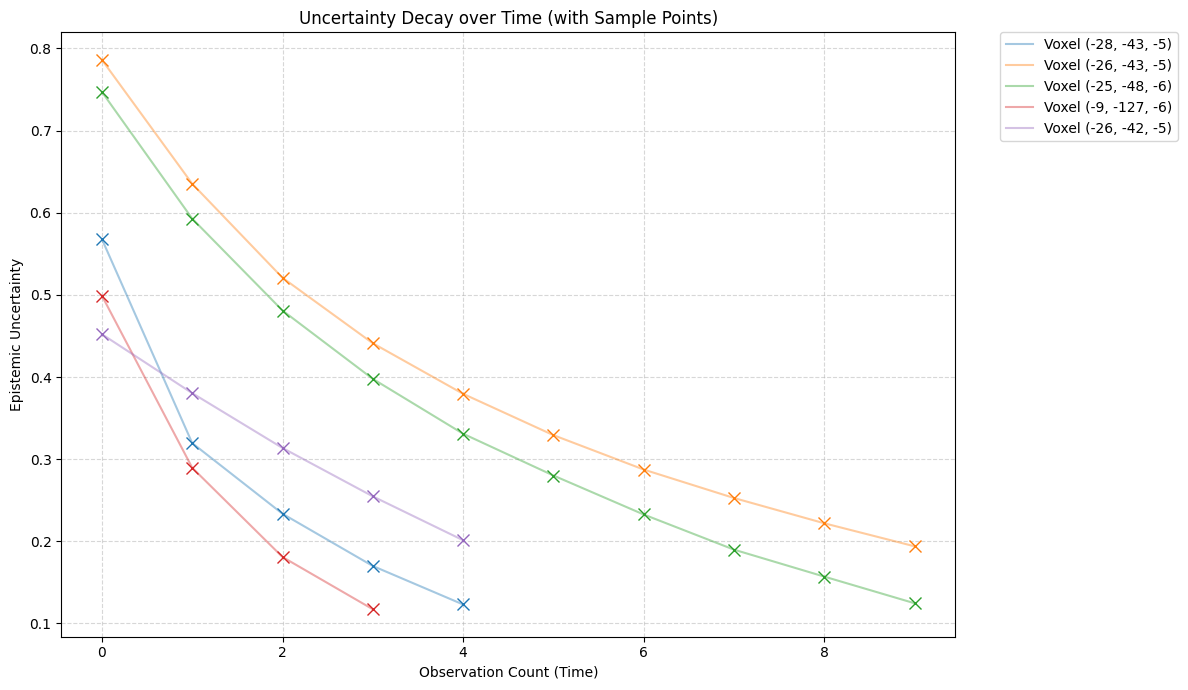

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# 遍历被监视的体素
for idx, uncs in global_map.watched_voxels.items():
    if len(uncs) > 3: # 只画观测次数超过3次的
        
        # 1. 绘制曲线 (设置 alpha=0.6 让线条稍微透明一点，以便凸显 'x')
        # plt.plot 返回一个列表，取 [0] 获得当前的 Line2D 对象
        line_plot = plt.plot(uncs, label=f'Voxel {idx}', alpha=0.4, linewidth=1.5)
        
        # 2. 获取刚才 Matplotlib 自动分配给这条线的颜色
        line_color = line_plot[0].get_color()
        
        # 3. 在数据点位置额外绘制 'x' 标记
        # linestyle='None': 不画线，只画点
        # marker='x': 标记形状
        # color=line_color: 保持颜色一致
        # alpha=1.0: 不透明度设为最高
        plt.plot(range(len(uncs)), uncs, 
                 linestyle='None', marker='x', markersize=8, 
                 color=line_color, alpha=1.0)

plt.xlabel('Observation Count (Time)')
plt.ylabel('Epistemic Uncertainty')
plt.title('Uncertainty Decay over Time (with Sample Points)')
plt.grid(True, linestyle='--', alpha=0.5)

# 如果图例太多，可以调整位置或者分栏，这里简单放在外侧防止遮挡
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# 调整布局以适应外置图例
plt.tight_layout()
plt.show()